# Tohoku Source Notebook

## Setup Environment

We assume you have installed `anuga` in your `python` environment. 

Some gauge data from  https://www.ngdc.noaa.gov/hazard/dart/2011honshu_dart.html and 
described in NOAA paper https://doi.org/10.1080/19475705.2011.632443. Also data is available from https://github.com/rjleveque/tohoku2011-paper1



### Setup inline graphics and animation

In [1]:
import os
import anuga
import numpy as np
import matplotlib.pyplot as plt
import utm
#from google.colab import files

%matplotlib inline
%load_ext memory_profiler

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

## Tohoku Folder

Change into the Tohoku folder (if you have not done that already)

In [2]:
print(f'Current directory {os.getcwd()}')
try:
    os.chdir('Tohoku')
except:
    pass




class Gauge:

    def __init__(self, long, lat, t1=0.0, t2= 1.e10):

        self.lat  = lat
        self.long = long

        self.t1 = t1
        self.t2 = t2

        import utm

        east, north, zone_no, zone_letter =  utm.from_latlon(self.lat, self.long, force_zone_number=54)

        self.east = east
        self.north = north
        self.zone_no = zone_no
        self.zone_letter = zone_letter


gauges = {}

gauges[21401] =  Gauge(152.583, 42.617, t1 = 1800.)
gauges[21413] =  Gauge(152.1167, 30.5153, t1 = 1800.)
#gauges[21414] = [178.281, 48.938,  1800., 1.e10]
#gauges[21415] = [171.849, 50.183,  1800., 1.e10]
#gauges[21416] = [163.505, 48.052,  1800., 1.e10]
gauges[21418] =  Gauge(148.694, 38.711)
gauges[21419] =  Gauge(155.736, 44.455,  t1 = 1800.)
#gauges[51407] = [203.484, 19.642, 22000., 1.e10]
#gauges[52402] = [154.116, 11.883, 10000., 1.e10]
gauges[0] = Gauge(141.0,38.0)


   




#print (gauges)
    #gauges[gauge_id] = gauge_data.append()


Current directory /home/steve/Tohoku


## Setup Anuga Model

### Project parameters

In [3]:
import project


Area of bounding polygon = 501600.00 km^2
Number of triangles: 82693
output directory: /home/steve/Tohoku/_output_Fujii
source directory: /home/steve/Tohoku/sources/Fujii.pts


project name:  Tohoku
Number of triangles =  87484
The extent is  (0.0, 880000.0, 0.0, 570000.0)
Geo reference is  (zone=54, easting=420000.000000, northing=3950000.000000, hemisphere=northern)
Figure files for each frame will be stored in _plot


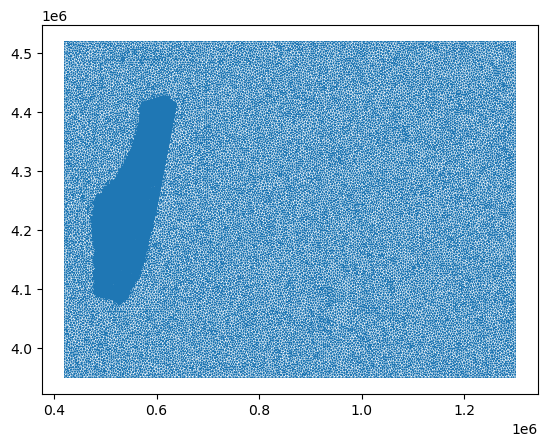

In [4]:
print ('project name: ', project.name_stem)
domain = anuga.create_domain_from_regions(project.bounding_polygon,
                                        boundary_tags={'bottom': [0],
                                                       'ocean_east': [1],
                                                       'top': [2],
                                                       'onshore': [3]},
                                        maximum_triangle_area=project.res_whole,
                                        mesh_filename=project.meshname,
                                        interior_regions=project.interior_regions,
                                        use_cache=False,
                                        verbose=False)



domain.set_hemisphere('northern')
domain.set_zone(54)
print ('Number of triangles = ', len(domain))
print ('The extent is ', domain.get_extent())
print ('Geo reference is ',domain.geo_reference)

domain.set_quantity('elevation',
                        filename=project.name_stem + '.pts',
                        use_cache=True,
                        verbose=False,
                        alpha=0.1)

domain.set_name('tohoku_source_example')


#tide = -0.45
tide = 0.0
domain.set_quantity('stage', tide)


Elevation = domain.quantities['elevation'].centroid_values
Stage     = domain.quantities['stage'].centroid_values

Stage[:] = np.maximum(Elevation, Stage)
                        

dplotter = anuga.Domain_plotter(domain, absolute=True)
plt.triplot(dplotter.triang, linewidth = 0.4);
#print (domain.statistics())

#domain.set_quantity('elevation', function=topography, location='centroids')

### View Elevation

Text(0.5, 1.0, 'Elevation (Bathymetry) east coast Japan')

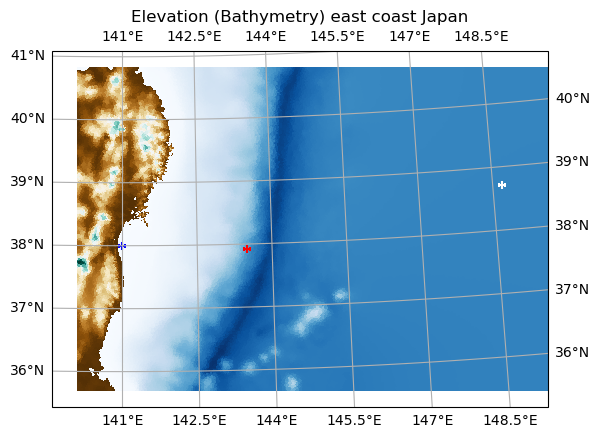

In [5]:
import cartopy
import cartopy.crs as ccrs

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
#ax = fig.add_subplot(111)






md = 0.01

# Dry areas
dplotter.triang.set_mask(dplotter.depth > md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='BrBG')
                      #cmap='viridis_r')
                      #cmap='Greys_r')

# Wet Areas
dplotter.triang.set_mask(dplotter.depth <= md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='Blues_r')
                      #cmap='viridis')
                      #vmin=vmin, vmax=vmax)

dplotter.triang.set_mask(None)

# plot epicentre (absolute)
x0 = 720000.0
y0 = 4200000.0
ax.scatter(x0, y0, marker='+', color='r')

# dart 21418 location 
ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# location on coast
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='b')

# for gauge_no, gauge_data in gauges.items():
#     print(gauge_no, gauge_data.east, gauge_data.north)
#     ax.scatter(gauge_data.east, gauge_data.north, marker='+', color='r')

# plot dart location



#ax.set_extent([450000,2000000,4000000, 4400000], crs=ccrs.UTM(zone=54))
gridlines = ax.gridlines(draw_labels=True)

#ax.coastlines()

plt.title('Elevation (Bathymetry) east coast Japan')

#plt.colorbar()



### Apply deformation to Stage and Elevation

Figure files for each frame will be stored in _plot
Stage extent      13.574795812652951 -2.166946396710285
Elevation extent  1612.3264338944925 -7944.719829134786
Depth extent      7944.598901784508 -1612.5447182712162


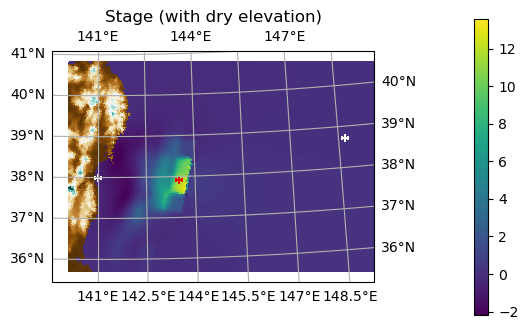

In [6]:
domain.add_quantity('stage',
                    filename=project.source_file,
                    use_cache=True,
                    verbose=False)

dplotter = anuga.Domain_plotter(domain, absolute=True)

print ('Stage extent     ',np.max(dplotter.stage), np.min(dplotter.stage))
print ('Elevation extent ',np.max(dplotter.elev), np.min(dplotter.elev))
print ('Depth extent     ',np.max(dplotter.depth), np.min(dplotter.depth))

# plt the updated elevation and stage
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
#ax = fig.add_subplot(111)

md = 0.01

# dry areas
dplotter.triang.set_mask(dplotter.depth > md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='BrBG')
                      #cmap='viridis_r')
                      #cmap='Greys_r')


# wet areas
dplotter.triang.set_mask(dplotter.depth <= md)
img = ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.stage,
                      #cmap='Blues_r')
                      cmap='viridis')
                      #vmin=vmin, vmax=vmax)

ax.set_aspect('equal', adjustable='box')

plt.colorbar(img, pad = 0.2, shrink=0.8)

ax.scatter(x0,y0,marker='+', color='r')

ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='w')

#ax.set_extent([400000,2500000,4000000, 4400000], crs=ccrs.UTM(zone=54))
gridlines = ax.gridlines(draw_labels=True)



#ax.coastlines()

plt.title('Stage (with dry elevation)');

### Setup Boundary Conditions

In [7]:
Br = anuga.Reflective_boundary(domain)
Bf = anuga.Flather_external_stage_zero_velocity_boundary(domain,lambda t :tide)
# Boundary conditions
domain.set_boundary({'onshore': Br,
                         'bottom': Bf,
                         'ocean_east': Bf,
                         'top': Bf})

                         

### Setup max min collection

In [8]:
from anuga.operators.collect_max_quantities_operator import Collect_max_quantities_operator

max_min_collector = Collect_max_quantities_operator(domain)


### Evolve the simulation

In [9]:
import time
t0 = time.time()
min = 60.
hour = 3600.

dplotter = anuga.Domain_plotter(domain, absolute=True)

tid_21418 = domain.get_triangle_containing_point([gauges[21418].east, gauges[21418].north])
gauge_21418_stage = []

tid_0 = domain.get_triangle_containing_point([gauges[0].east, gauges[0].north])
gauge_0_stage = []

gauge_time =[]

# Initial run without any event
for t in domain.evolve(yieldstep=2*min, finaltime=2.0*hour):

    gauge_21418_stage.append(dplotter.stage[tid_21418])
    gauge_0_stage.append(dplotter.stage[tid_0])
    gauge_time.append(t)


    dplotter.save_stage_frame(vmin=-2.0,vmax=14.0)

    domain.print_timestepping_statistics()

print ('That took %.2f seconds' %(time.time()-t0))


Figure files for each frame will be stored in _plot


/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1161: RuntimeWarning: invalid value encountered in multiply
  w1 = 0.0 - sqrt_g_on_depth_inside * stage_outside
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1165: RuntimeWarning: invalid value encountered in divide
  (n2 * Xmom.boundary_values[ids] - n1 * Ymom.boundary_values[ids])/depth_inside,
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1168: RuntimeWarning: invalid value encountered in divide
  w3 = ndotq_inside/depth_inside + sqrt_g_on_depth_inside*Stage.boundary_values[ids]


Time = 0.0000 (sec), steps=0 (20s)
Time = 120.0000 (sec), delta t in [1.73362814, 1.73362828] (s), steps=70 (6s)
Time = 240.0000 (sec), delta t in [1.73362403, 1.73362836] (s), steps=70 (5s)
Time = 360.0000 (sec), delta t in [1.73362323, 1.73362402] (s), steps=70 (5s)
Time = 480.0000 (sec), delta t in [1.73362325, 1.73362336] (s), steps=70 (5s)
Time = 600.0000 (sec), delta t in [1.73362335, 1.73362345] (s), steps=70 (5s)
Time = 720.0000 (sec), delta t in [1.73362345, 1.73362352] (s), steps=70 (5s)
Time = 840.0000 (sec), delta t in [1.73362352, 1.73362432] (s), steps=70 (5s)
Time = 960.0000 (sec), delta t in [1.73362434, 1.73362909] (s), steps=70 (6s)
Time = 1080.0000 (sec), delta t in [1.73362904, 1.73362930] (s), steps=70 (6s)
Time = 1200.0000 (sec), delta t in [1.73362930, 1.73362954] (s), steps=70 (7s)
Time = 1320.0000 (sec), delta t in [1.73362954, 1.73362988] (s), steps=70 (5s)
Time = 1440.0000 (sec), delta t in [1.73362988, 1.73363097] (s), steps=70 (5s)
Time = 1560.0000 (sec), d

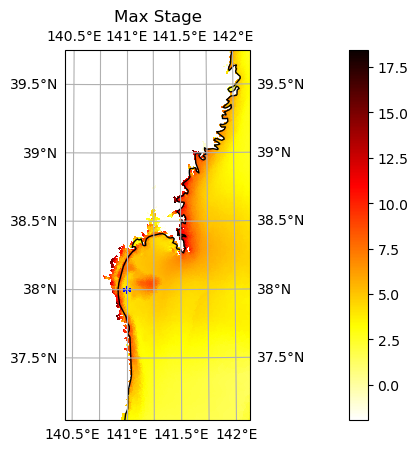

In [24]:
max_depth = max_min_collector.max_depth
max_stage = max_min_collector.max_stage

wet_mask = max_depth >= 0.01

wet_max_stage = np.where(max_depth >= 0.01, max_stage, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
#ax = fig.add_subplot(111)



img = ax.tripcolor(dplotter.triang,
                      facecolors=wet_max_stage,
                      #cmap='BrBG')
                      #cmap='viridis_r')
                      cmap='hot_r')
                      #cmap='Greys_r')


# plot epicentre (absolute)
x0 = 720000.0
y0 = 4200000.0
ax.scatter(x0, y0, marker='+', color='r')

# dart 21418 location 
ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# location on coast
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='b')




ax.set_extent([450000,600000,4100000, 4400000], crs=ccrs.UTM(zone=54))
gridlines = ax.gridlines(draw_labels=True)

ax.coastlines()

plt.title('Max Stage')
plt.colorbar(img, pad = 0.2, shrink=1.0)



In [12]:
dplotter.make_stage_animation()

--- Logging error ---
Traceback (most recent call last):
  File "/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/logging/__init__.py", line 434, in format
    return self._format(record)
  File "/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/logging/__init__.py", line 430, in _format
    return self._fmt % record.__dict__
KeyError: 'mname'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/logging/__init__.py", line 666, in format
    s = self.formatMessage(record)
  File "/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/logging/__init__.py", line 635, in formatMessage
    return self._

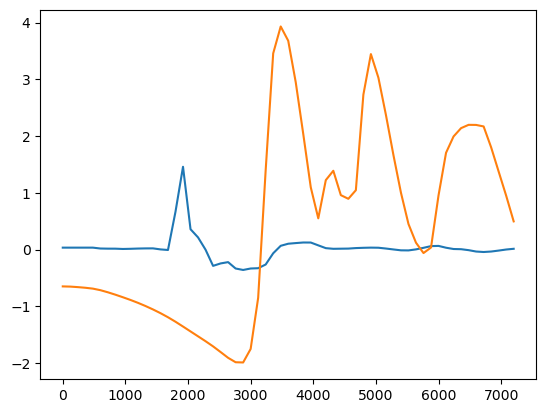

In [13]:
t = np.array(gauge_time)
stage_21418 = np.array(gauge_21418_stage)
stage_0 = np.array(gauge_0_stage)


plt.plot(t, stage_21418)
plt.plot(t, stage_0)

In [13]:
splotter = anuga.SWW_plotter('tohoku_source_example.sww')




Figure files for each frame will be stored in _plot


In [14]:
wet_mask = splotter.depth >= 0.01

wet_stage = np.where(splotter.depth >= 0.01, splotter.stage, np.nan)

wet_max_stage = np.nanmax(wet_stage, axis=0)

wet_max_stage.shape

/tmp/ipykernel_15588/2738018229.py:5: RuntimeWarning: All-NaN slice encountered
  wet_max_stage = np.nanmax(wet_stage, axis=0)


(87484,)

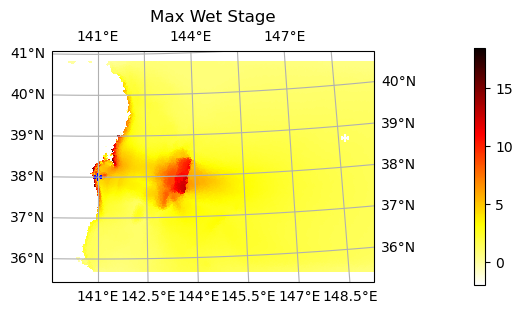

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
#ax = fig.add_subplot(111)



img = ax.tripcolor(dplotter.triang,
                      facecolors=wet_max_stage,
                      #cmap='BrBG')
                      cmap='hot_r')
                      #cmap='viridis_r')
                      #cmap='Greys_r')


# plot epicentre (absolute)
x0 = 720000.0
y0 = 4200000.0
ax.scatter(x0, y0, marker='+', color='r')

# dart 21418 location 
ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# location on coast
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='b')




#ax.set_extent([450000,2000000,4000000, 4400000], crs=ccrs.UTM(zone=54))
gridlines = ax.gridlines(draw_labels=True)

#ax.coastlines()

plt.title('Max Wet Stage')

plt.colorbar(img, pad = 0.2, shrink=0.64)
